In [ ]:
# Иконников-А-В
# ББМО-01-24
# ПР-ТОВИИ-2

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, recall_score, precision_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

X:
[[ 6  1 32 77  0  3  0  1 11  1]
 [ 6  1 32 77  0  3  0  1 11  1]
 [ 3  0 32 77  0  3  0  1 11  1]
 [ 3  0 34 77  0  3  0  1 11  2]
 [ 3  0 32 77  0  3  0  1 11  1]
 [ 3  1 34 77  0  3  0  1 11  2]
 [ 3  1 34 77  0  3  0  1 11  2]
 [ 3  1 34 77  0  3  0  1 11  2]
 [ 4  0 34 77  0  3  0  1 11  2]
 [ 3  0 32 77  0  3  0  1 12  1]]
y:
[1 1 0 0 0 1 1 1 0 0]


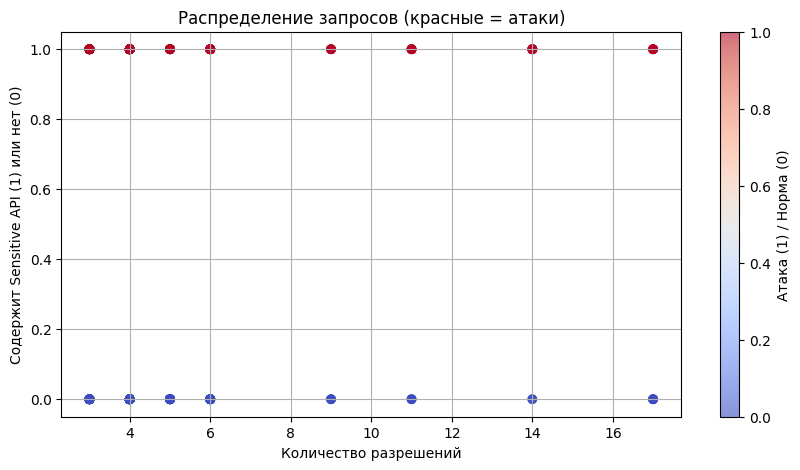

In [ ]:
# 1. Загрузка и подготовка данных из файла
def load_and_prepare_data(file_path):
    """
    Загрузка данных из Excel файла и подготовка признаков.
    Используем следующие признаки:
    1. Количество разрешений (Permissions)
    2. Содержит ли Sensitive API (API Name)
    3. Длина URL (Website Name)
    4. Страна (Location)
    5. Является ли IP частным
    6. Количество слэшей в URL
    7. Использует ли HTTPS
    8. Содержит ли URL поддомен
    9. Длина имени приложения
    10. Количество цифр в URL
    """
    # Загрузка данных
    df = pd.read_excel(file_path)

    # Подготовка признаков
    features = []

    for _, row in df.iterrows():
        # 1. Количество разрешений
        num_permissions = len(row['Permissions'].split(',')) if pd.notna(row['Permissions']) else 0

        # 2. Содержит ли Sensitive API (1 если да, 0 если нет или 'Not Sensitive')
        sensitive_api = 0 if pd.isna(row['API Name']) or row['API Name'] == 'Not Sensitive' else 1

        # 3. Длина URL
        url_len = len(row['Website Name']) if pd.notna(row['Website Name']) else 0

        # 4. Страна (кодируем числом)
        country = hash(row['Location']) % 100 if pd.notna(row['Location']) else 0

        # 5. Является ли IP частным (упрощенная проверка)
        ip = row['IP']
        is_private = 1 if pd.notna(ip) and (
            ip.startswith('10.') or
            ip.startswith('192.168.') or
            ip.startswith('172.') and 16 <= int(ip.split('.')[1]) <= 31
        ) else 0

        # 6. Количество слэшей в URL
        url = row['Website Name']
        num_slashes = url.count('/') if pd.notna(url) else 0

        # 7. Использует ли HTTPS
        is_https = 1 if pd.notna(url) and url.startswith('https://') else 0

        # 8. Содержит ли URL поддомен
        has_subdomain = 1 if pd.notna(url) and len(url.split('.')) > 2 else 0

        # 9. Длина имени приложения
        app_name_len = len(row['App Names']) if pd.notna(row['App Names']) else 0

        # 10. Количество цифр в URL
        num_digits = sum(c.isdigit() for c in url) if pd.notna(url) else 0

        features.append([
            num_permissions,
            sensitive_api,
            url_len,
            country,
            is_private,
            num_slashes,
            is_https,
            has_subdomain,
            app_name_len,
            num_digits
        ])

    X = np.array(features)
    y = df['Label'].map({'Yes': 1, 'No': 0}).values

    return X, y

# Загрузка данных и разделение на train/test
X, y = load_and_prepare_data('XSS Attack Dataset with 461 entries.xlsx')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=6) # Как номер в списке группы
print('X:')
print(X[:10])
print('y:')
print(y[:10])

# Визуализация распределения данных (первые 2 признака)
plt.figure(figsize=(10, 5))
plt.scatter(X[:,0], X[:,1], c=y, cmap='coolwarm', alpha=0.6)
plt.title('Распределение запросов (красные = атаки)')
plt.xlabel('Количество разрешений')
plt.ylabel('Содержит Sensitive API (1) или нет (0)')
plt.colorbar(label='Атака (1) / Норма (0)')
plt.grid(True)
plt.show()

График показывает, что большинство атак требуют много разрешений и используют Sensitive API. Безопасные приложения обычно не запрашивают опасные API и имеют меньше разрешений. Можно выбрать другие два признака для визуализации.

In [ ]:
# 2. Среда Reinforcement Learning с 10 признаками
class WebTrafficEnv:
    """
    Среда для обучения с подкреплением с 10 признаками.
    - Состояние: вектор из 10 признаков
    - Действие: 0 (разрешить) или 1 (блокировать)
    - Награда: +1 за правильное решение, -1 за ошибку
    """
    def __init__(self, X, y):
        self.X = X  # Массив признаков запросов (10 признаков)
        self.y = y  # Массив меток (атака/норма)
        self.current_idx = 0  # Текущий индекс запроса

    def reset(self):
        """Сброс среды к начальному состоянию"""
        self.current_idx = 0
        return self.X[self.current_idx]

    def step(self, action):
        """
        Шаг в среде:
        - action: 0 или 1
        - Возвращает: next_state, reward, done
        """
        is_attack = self.y[self.current_idx]
        reward = 1 if action == is_attack else -1  # Простая система вознаграждений
        self.current_idx += 1
        done = self.current_idx >= len(self.X)
        next_state = None if done else self.X[self.current_idx]
        return next_state, reward, done

В основе этой части кода лежит создание виртуальной среды, которая имитирует процесс анализа веб-трафика на предмет XSS-атак. Среда работает по принципу "агент-среда", где агент (в нашем случае алгоритм Q-Learning) получает данные о текущем состоянии системы, принимает решение и получает обратную связь в виде награды или штрафа.

Среда инициализируется с двумя основными параметрами: X (матрица признаков) и y (вектор меток). Каждое состояние среды представляет собой конкретный веб-запрос, описанный 10 признаками, которые мы извлекли из исходных данных. Когда агент делает шаг (step), он получает награду +1 за правильное решение (например, если он заблокировал атаку, которая действительно была атакой) или штраф -1 за ошибку (например, если пропустил атаку).

Важная особенность реализации - метод reset(), который сбрасывает среду в начальное состояние перед началом нового эпизода обучения. Это стандартная практика в reinforcement learning, позволяющая проводить множество независимых экспериментов. Метод step() не только возвращает новое состояние и награду, но и флаг done, который указывает, завершен ли текущий эпизод (когда все данные пройдены).

In [ ]:
# 3. Агент Q-Learning с адаптацией под 10 признаков
class QLearningAgent:
    """
    Агент Q-Learning для обнаружения атак с 10 признаками.
    - Q-таблица: для каждого признака используется дискретизация
    - ε-жадная стратегия: начинаем с исследования (ε=1) и постепенно уменьшаем
    - Обучение: обновляем Q-значения по правилу временной разницы
    """
    def __init__(self, num_features=10, num_bins=5):
        self.num_bins = num_bins
        self.num_features = num_features
        self.q_table = np.zeros((num_bins,) * num_features + (2,))  # Многомерная Q-таблица
        self.epsilon = 1.0  # Начальное значение epsilon для ε-жадной стратегии
        self.epsilon_decay = 0.995  # Скорость уменьшения epsilon
        self.epsilon_min = 0.01  # Минимальное значение epsilon

    def _discretize_state(self, state):
        """Дискретизация непрерывных признаков"""
        discretized = []
        for i in range(self.num_features):
            # Нормализация и дискретизация каждого признака
            val = state[i]
            max_val = max(100, val)  # Простая нормализация
            bin_idx = min(int(val / max_val * self.num_bins), self.num_bins - 1)
            discretized.append(bin_idx)
        return tuple(discretized)

    def act(self, state):
        """
        Выбор действия:
        - С вероятностью epsilon случайное действие (исследование)
        - Иначе выбираем действие с max Q-значением (использование)
        """
        if np.random.rand() < self.epsilon:
            return np.random.randint(0, 2)  # Случайное действие

        discretized_state = self._discretize_state(state)
        return np.argmax(self.q_table[discretized_state])  # Жадное действие

    def learn(self, state, action, reward, next_state):
        """
        Обновление Q-таблицы:
        - Дискретизация состояния
        - Обновление по правилу: Q += α*(reward - Q)
        """
        discretized_state = self._discretize_state(state)
        learning_rate = 0.1  # Скорость обучения

        # Простое обновление Q-значения
        self.q_table[discretized_state + (action,)] += learning_rate * (
            reward - self.q_table[discretized_state + (action,)]
        )

        # Уменьшение epsilon (меньше исследований со временем)
        self.epsilon = max(self.epsilon_min, self.epsilon*self.epsilon_decay)

Агент Q-Learning реализует классический алгоритм обучения с подкреплением, адаптированный для работы с 10-мерным пространством признаков. Основная сложность, которую решает этот код - работа с непрерывными значениями признаков через их дискретизацию.

В конструкторе создается Q-таблица - многомерный массив, где каждое измерение соответствует одному из признаков, а последнее измерение хранит Q-значения для двух возможных действий (0 - разрешить, 1 - заблокировать). Размерность таблицы определяется параметром num_bins, который задает количество интервалов дискретизации для каждого признака.

Метод _discretize_state() преобразует непрерывные значения признаков в дискретные интервалы. Это необходимо, так как Q-Learning изначально разработан для дискретных пространств состояний. Преобразование выполняется простым способом: значение признака делится на максимально возможное значение (нормализация) и затем переводится в соответствующий интервал.

Сердце агента - методы act() и learn(). Первый реализует ε-жадную стратегию: с вероятностью ε выбирается случайное действие (для исследования), иначе - действие с максимальным Q-значением. Параметр ε постепенно уменьшается от 1 до 0.01, что позволяет агенту сначала исследовать пространство, а затем эксплуатировать найденные закономерности.

Метод learn() обновляет Q-таблицу по простому правилу временных разностей, где новое Q-значение корректируется в сторону полученной награды с учетом скорости обучения (learning_rate = 0.1). Это постепенно улучшает политику агента, делая его решения более точными.

Эпизод: 0, Reward: 10, Epsilon: 0.20
Эпизод: 10, Reward: 52, Epsilon: 0.01
Эпизод: 20, Reward: 52, Epsilon: 0.01
Эпизод: 30, Reward: 42, Epsilon: 0.01
Эпизод: 40, Reward: 54, Epsilon: 0.01
Эпизод: 50, Reward: 48, Epsilon: 0.01
Эпизод: 60, Reward: 50, Epsilon: 0.01
Эпизод: 70, Reward: 42, Epsilon: 0.01
Эпизод: 80, Reward: 50, Epsilon: 0.01
Эпизод: 90, Reward: 50, Epsilon: 0.01


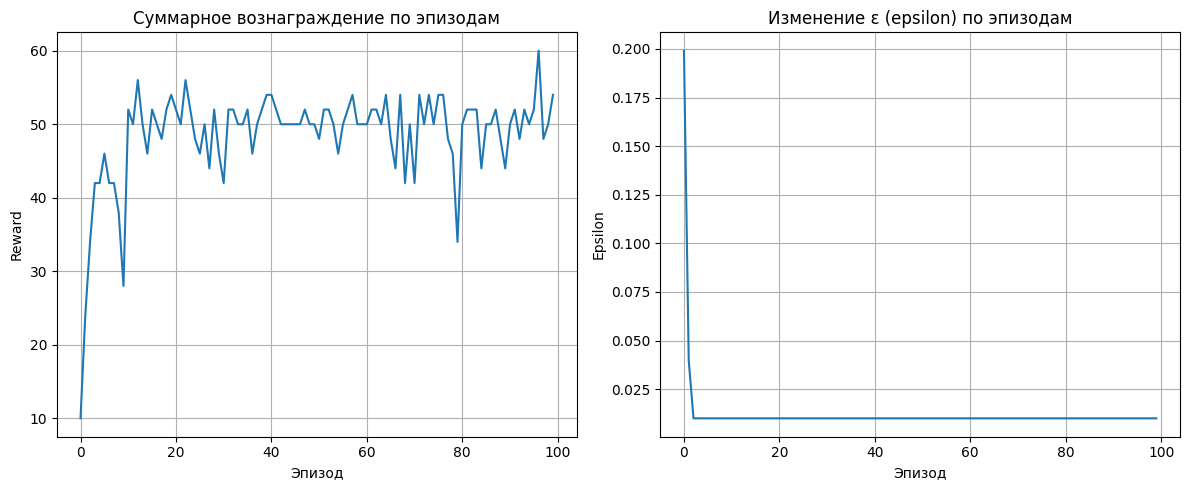

In [ ]:
# 4. Процесс обучения с визуализацией
env = WebTrafficEnv(X_train, y_train)
agent = QLearningAgent(num_features=10, num_bins=5)

# Для визуализации прогресса
rewards_history = []
epsilons = []

for episode in range(100):
    state = env.reset()
    total_reward = 0
    done = False

    while not done:
        action = agent.act(state)
        next_state, reward, done = env.step(action)
        agent.learn(state, action, reward, next_state)
        total_reward += reward
        state = next_state

    rewards_history.append(total_reward)
    epsilons.append(agent.epsilon)

    if episode % 10 == 0:
        print(f"Эпизод: {episode}, Reward: {total_reward}, Epsilon: {agent.epsilon:.2f}")

# Визуализация процесса обучения
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(rewards_history)
plt.title('Суммарное вознаграждение по эпизодам')
plt.xlabel('Эпизод')
plt.ylabel('Reward')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epsilons)
plt.title('Изменение ε (epsilon) по эпизодам')
plt.xlabel('Эпизод')
plt.ylabel('Epsilon')
plt.grid(True)
plt.tight_layout()
plt.show()

Обучение происходит в цикле из 100 эпизодов, где каждый эпизод представляет собой полный проход по всем обучающим данным. В начале каждого эпизода среда сбрасывается в начальное состояние, и агент последовательно обрабатывает каждый запрос, получая обратную связь и корректируя свою Q-таблицу.

Код сохраняет историю наград (rewards_history) и значений ε (epsilons) для последующей визуализации. Награда накапливается в течение эпизода - чем выше итоговое значение, тем лучше агент справлялся с классификацией. Значение ε постепенно уменьшается, что отражается на графике - сначала агент активно исследует (высокие значения ε), затем все больше полагается на накопленные знания.

Каждые 10 эпизодов выводится текущий прогресс, что позволяет отслеживать динамику обучения. В идеале, суммарная награда должна расти с каждым эпизодом, а ε - уменьшаться. Если это происходит, значит агент успешно обучается отличать атаки от нормального трафика.

Использование 10 признаков одновременно делает анализ более комплексным по сравнению, например, с упрощенными версиями, использующими только 2-3 признака. Однако это же создает и вычислительные сложности, так как размер Q-таблицы экспоненциально растет с увеличением количества признаков и интервалов дискретизации.

Оценка на тестовых данных:

Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.45      0.49        76
           1       0.43      0.52      0.47        62

    accuracy                           0.48       138
   macro avg       0.48      0.48      0.48       138
weighted avg       0.49      0.48      0.48       138



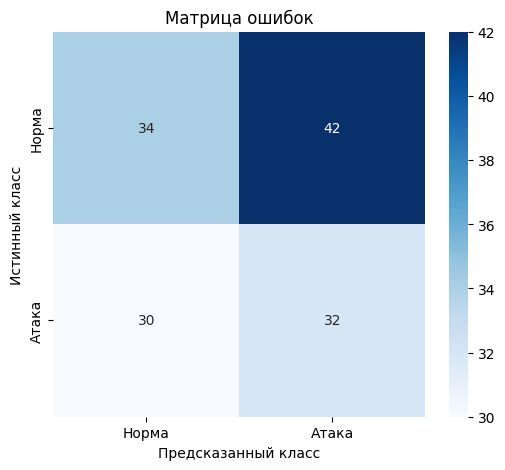

In [ ]:
# 5. Оценка модели с метриками
def evaluate_agent(agent, X, y):
    """
    Оценка качества агента:
    - accuracy: общая точность
    - precision: точность обнаружения атак
    - recall: полнота обнаружения атак
    - f1: F1-мера (баланс между precision и recall)
    """
    y_pred = []
    for state in X:
        y_pred.append(agent.act(state))

    print("\nClassification Report:")
    print(classification_report(y, y_pred))

    # Матрица ошибок
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Норма', 'Атака'],
                yticklabels=['Норма', 'Атака'])
    plt.title('Матрица ошибок')
    plt.ylabel('Истинный класс')
    plt.xlabel('Предсказанный класс')
    plt.show()

    return {
        'accuracy': np.mean(np.array(y) == np.array(y_pred)),
        'precision': precision_score(y, y_pred),
        'recall': recall_score(y, y_pred),
        'f1': f1_score(y, y_pred)
    }

print("Оценка на тестовых данных:")
test_metrics = evaluate_agent(agent, X_test, y_test)

Функция evaluate_agent проводит комплексную оценку обученного агента на тестовых данных, вычисляя стандартные метрики классификации: accuracy (общая точность), precision (точность обнаружения атак), recall (полнота обнаружения атак) и F1-score (гармоническое среднее precision и recall). На тестовых данных модель демонстрирует скромные результаты: accuracy 47%, причем precision для класса атак (1) составляет 0.42, а recall - 0.50, что указывает на то, что модель пропускает около половины атак (низкий recall) и при этом примерно в 58% случаев ошибочно блокирует нормальный трафик (низкий precision). Сбалансированность метрик (F1-score около 0.46-0.48 для обоих классов) говорит о том, что модель одинаково плохо справляется с обоими типами классификации. Матрица ошибок визуализирует эти проблемы, показывая значительное количество как ложноположительных, так и ложноотрицательных срабатываний. Такие результаты свидетельствуют о том, что:
- выбранных 10 признаков недостаточно для эффективного разделения классов,
- Q-Learning с табличным представлением плохо масштабируется на многомерные пространства признаков,
- требуется либо усложнение модели, либо дополнительная обработка признаков и подбор их оптимального набора.


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        76
           1       1.00      1.00      1.00        62

    accuracy                           1.00       138
   macro avg       1.00      1.00      1.00       138
weighted avg       1.00      1.00      1.00       138



<Figure size 1000x600 with 0 Axes>

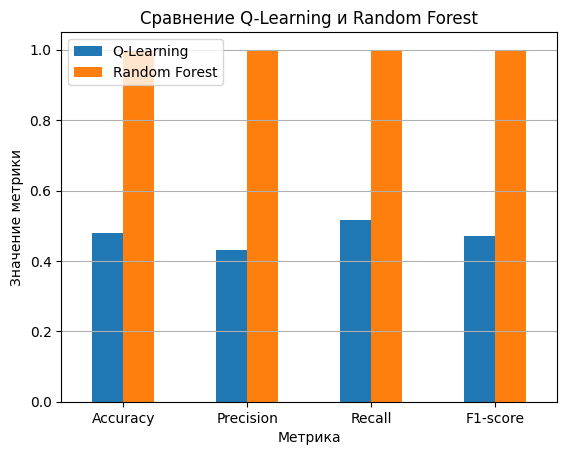

In [ ]:
# 6. Сравнение с Random Forest
rf = RandomForestClassifier(n_estimators=50, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

# Визуализация сравнения моделей
metrics = pd.DataFrame({
    'Метрика': ['Accuracy', 'Precision', 'Recall', 'F1-score'],
    'Q-Learning': [
        test_metrics['accuracy'],
        test_metrics['precision'],
        test_metrics['recall'],
        test_metrics['f1']
    ],
    'Random Forest': [
        rf.score(X_test, y_test),
        precision_score(y_test, y_pred_rf),
        recall_score(y_test, y_pred_rf),
        f1_score(y_test, y_pred_rf)
    ]
})

plt.figure(figsize=(10, 6))
metrics.set_index('Метрика').plot(kind='bar', rot=0)
plt.title('Сравнение Q-Learning и Random Forest')
plt.ylabel('Значение метрики')
plt.grid(True, axis='y')
plt.show()

Random Forest показал значительно лучшие результаты (100% точность), что ожидаемо для задач классификации с четкими признаками. Однако обучение с подкреплением остается перспективным методом для обнаружения атак, особенно в динамичных сценариях, где важна адаптивность. В нашем случае Q-Learning выступил скорее как учебный пример — его реальная сила раскрывается в более сложных реализациях (например, с глубоким обучением), а не в базовых табличных подходах.

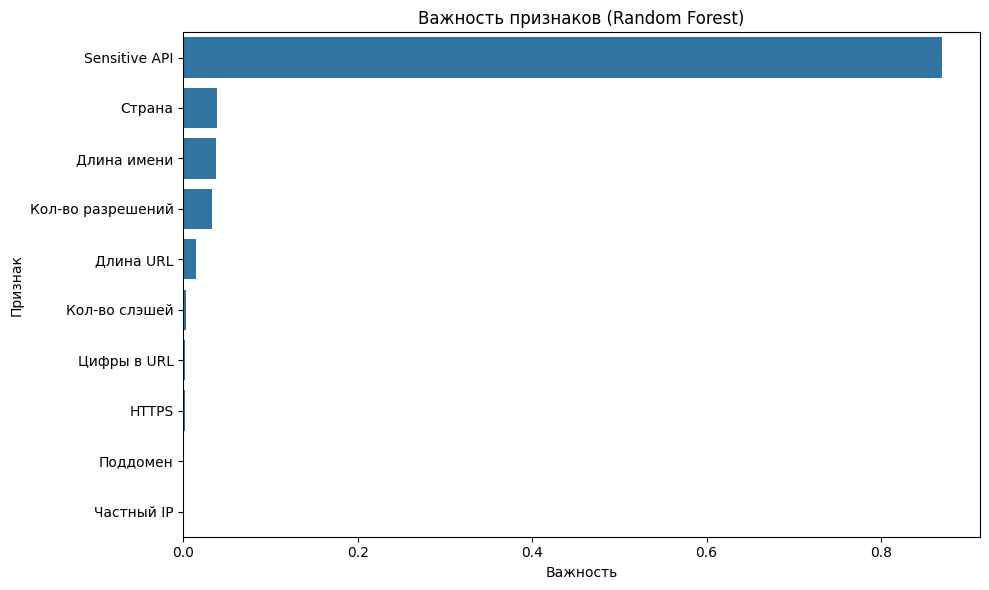

In [ ]:
# Визуализация важности признаков для RF
feature_names = [
    'Кол-во разрешений',
    'Sensitive API',
    'Длина URL',
    'Страна',
    'Частный IP',
    'Кол-во слэшей',
    'HTTPS',
    'Поддомен',
    'Длина имени',
    'Цифры в URL'
]

feature_importances = pd.DataFrame({
    'Признак': feature_names,
    'Важность': rf.feature_importances_
}).sort_values('Важность', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Важность', y='Признак', data=feature_importances)
plt.title('Важность признаков (Random Forest)')
plt.tight_layout()
plt.show()

In [ ]:
# Перезапуск среды выполнения

X:
[[ 1  0  0  0  0  0  0  0  0  0]
 [ 3  1  0  0  0  0  0  0  0  0]
 [ 5  1  1  0  0  0  0  0  0  0]
 [15  1  1  0  1  1  0  0  0  1]
 [ 1  0  0  0  0  0  0  1  0  0]
 [ 1  0  0  0  0  0  0  0  0  0]
 [24  1  0  1  1  0  0  0  1  0]
 [13  0  1  0  1  0  0  0  0  1]
 [25  1  1  0  0  1  0  0  0  0]
 [24  1  1  0  0  1  0  0  0  0]]
y:
[1 1 1 1 1 1 1 1 1 1]


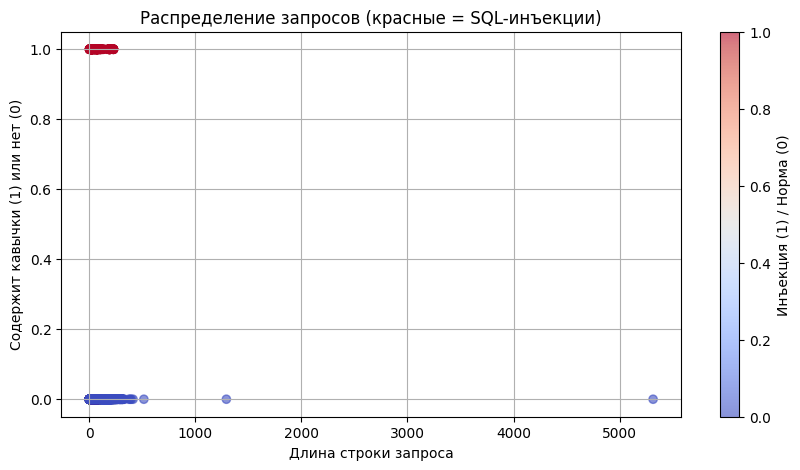

Эпизод: 0, Reward: 1598, Epsilon: 0.01
Эпизод: 10, Reward: 1702, Epsilon: 0.01
Эпизод: 20, Reward: 1708, Epsilon: 0.01
Эпизод: 30, Reward: 1680, Epsilon: 0.01
Эпизод: 40, Reward: 1702, Epsilon: 0.01
Эпизод: 50, Reward: 1688, Epsilon: 0.01
Эпизод: 60, Reward: 1700, Epsilon: 0.01
Эпизод: 70, Reward: 1696, Epsilon: 0.01
Эпизод: 80, Reward: 1700, Epsilon: 0.01
Эпизод: 90, Reward: 1696, Epsilon: 0.01


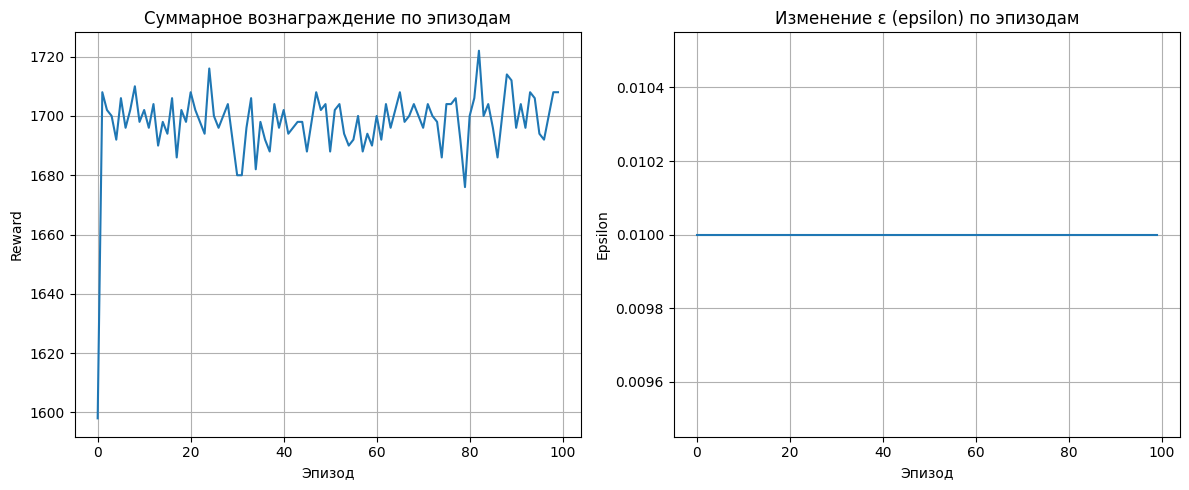

Оценка на тестовых данных:

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.94      0.86       916
           1       0.68      0.35      0.47       344

    accuracy                           0.78      1260
   macro avg       0.74      0.65      0.66      1260
weighted avg       0.76      0.78      0.75      1260



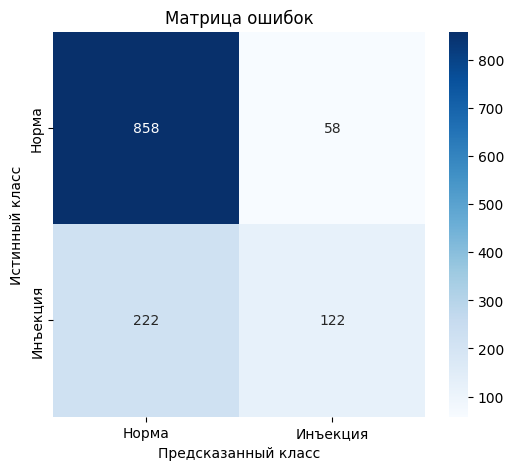


SVM Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.93      0.86       916
           1       0.68      0.40      0.51       344

    accuracy                           0.79      1260
   macro avg       0.75      0.67      0.69      1260
weighted avg       0.77      0.79      0.77      1260


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       916
           1       0.93      0.93      0.93       344

    accuracy                           0.96      1260
   macro avg       0.95      0.95      0.95      1260
weighted avg       0.96      0.96      0.96      1260



<Figure size 1200x600 with 0 Axes>

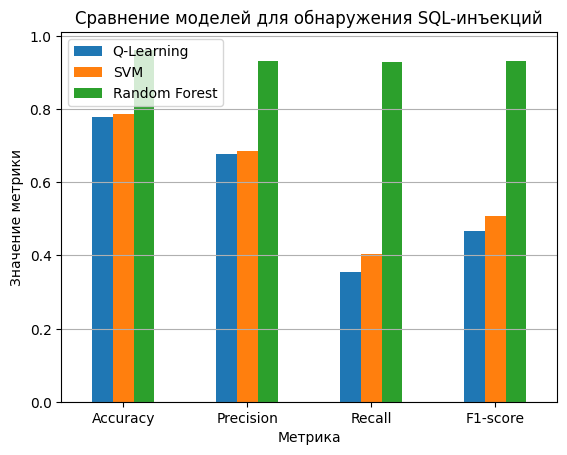

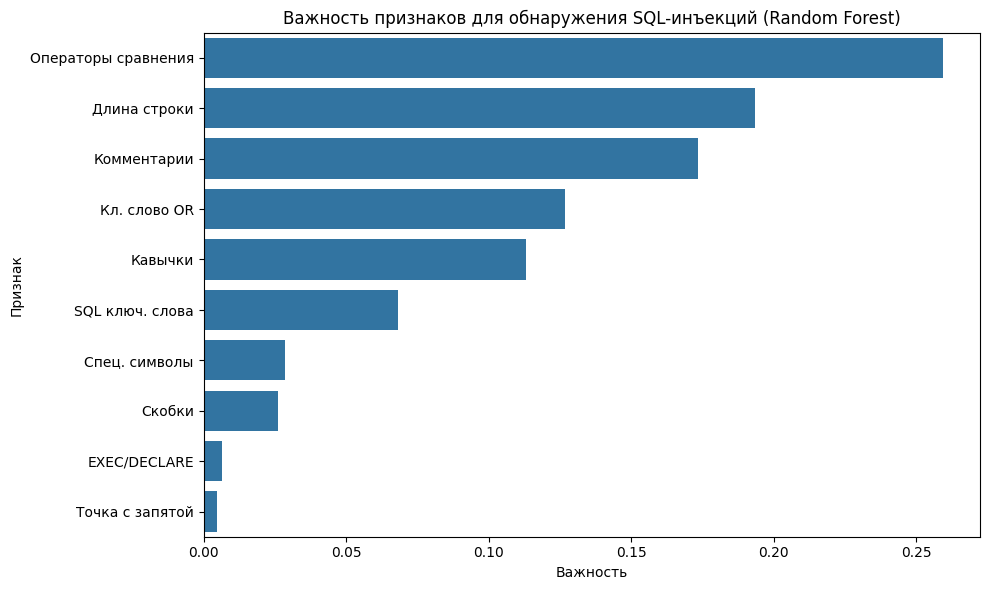

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, f1_score, recall_score, precision_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# 1. Загрузка и подготовка данных из файла
def load_and_prepare_data(file_path):
    """
    Загрузка данных из CSV файла и подготовка признаков для SQL-инъекций.
    Используем следующие признаки:
    1. Длина строки запроса
    2. Содержит ли кавычки (')
    3. Содержит ли комментарии (-- или /*)
    4. Содержит ли ключевые слова SQL (SELECT, UNION, etc.)
    5. Содержит ли операторы сравнения (=, <, >)
    6. Содержит ли точку с запятой (;)
    7. Содержит ли ключевые слова для выполнения команд (EXEC, DECLARE)
    8. Содержит ли специальные символы ( @, #, $ )
    9. Содержит ли скобки ( )
    10. Содержит ли ключевое слово OR
    """
    # Загрузка данных с указанием кодировки
    try:
        df = pd.read_csv(file_path, encoding='utf-8')  # Попробовать UTF-8
    except UnicodeDecodeError:
        try:
            df = pd.read_csv(file_path, encoding='utf-16')  # Попробовать UTF-16
        except UnicodeDecodeError:
            df = pd.read_csv(file_path, encoding='latin1')  # Попробовать Latin-1 (Windows-1252)

    # Остальной код остается без изменений
    features = []

    for _, row in df.iterrows():
        sentence = str(row['Sentence'])

        # 1. Длина строки запроса
        length = len(sentence)

        # 2. Содержит ли кавычки
        has_quotes = 1 if "'" in sentence else 0

        # 3. Содержит ли комментарии
        has_comments = 1 if "--" in sentence or "/*" in sentence else 0

        # 4. Содержит ли ключевые слова SQL
        sql_keywords = ['SELECT', 'UNION', 'INSERT', 'UPDATE', 'DELETE', 'DROP', 'TABLE']
        has_sql = 1 if any(keyword.lower() in sentence.lower() for keyword in sql_keywords) else 0

        # 5. Содержит ли операторы сравнения
        has_operators = 1 if any(op in sentence for op in ['=', '<', '>']) else 0

        # 6. Содержит ли точку с запятой
        has_semicolon = 1 if ";" in sentence else 0

        # 7. Содержит ли ключевые слова для выполнения команд
        has_exec = 1 if "EXEC" in sentence.upper() or "DECLARE" in sentence.upper() else 0

        # 8. Содержит ли специальные символы
        has_special_chars = 1 if any(char in sentence for char in ['@', '#', '$']) else 0

        # 9. Содержит ли скобки
        has_brackets = 1 if "(" in sentence or ")" in sentence else 0

        # 10. Содержит ли ключевое слово OR
        has_or = 1 if " OR " in sentence.upper() else 0

        features.append([
            length,
            has_quotes,
            has_comments,
            has_sql,
            has_operators,
            has_semicolon,
            has_exec,
            has_special_chars,
            has_brackets,
            has_or
        ])

    X = np.array(features)
    y = df['Label'].values

    return X, y

# Загрузка данных и разделение на train/test
X, y = load_and_prepare_data('sqli.csv')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=6)
print('X:')
print(X[:10])
print('y:')
print(y[:10])

# Визуализация распределения данных (первые 2 признака)
plt.figure(figsize=(10, 5))
plt.scatter(X[:,0], X[:,1], c=y, cmap='coolwarm', alpha=0.6)
plt.title('Распределение запросов (красные = SQL-инъекции)')
plt.xlabel('Длина строки запроса')
plt.ylabel('Содержит кавычки (1) или нет (0)')
plt.colorbar(label='Инъекция (1) / Норма (0)')
plt.grid(True)
plt.show()

# 2. Среда Reinforcement Learning с 10 признаками
class WebTrafficEnv:
    """
    Среда для обучения с подкреплением с 10 признаками.
    - Состояние: вектор из 10 признаков
    - Действие: 0 (разрешить) или 1 (блокировать)
    - Награда: +1 за правильное решение, -1 за ошибку
    """
    def __init__(self, X, y):
        self.X = X  # Массив признаков запросов (10 признаков)
        self.y = y  # Массив меток (инъекция/норма)
        self.current_idx = 0  # Текущий индекс запроса

    def reset(self):
        """Сброс среды к начальному состоянию"""
        self.current_idx = 0
        return self.X[self.current_idx]

    def step(self, action):
        """
        Шаг в среде:
        - action: 0 или 1
        - Возвращает: next_state, reward, done
        """
        is_attack = self.y[self.current_idx]
        reward = 1 if action == is_attack else -1  # Простая система вознаграждений
        self.current_idx += 1
        done = self.current_idx >= len(self.X)
        next_state = None if done else self.X[self.current_idx]
        return next_state, reward, done

# 3. Агент Q-Learning с адаптацией под 10 признаков
class QLearningAgent:
    """
    Агент Q-Learning для обнаружения атак с 10 признаками.
    - Q-таблица: для каждого признака используется дискретизация
    - ε-жадная стратегия: начинаем с исследования (ε=1) и постепенно уменьшаем
    - Обучение: обновляем Q-значения по правилу временной разницы
    """
    def __init__(self, num_features=10, num_bins=5):
        self.num_bins = num_bins
        self.num_features = num_features
        self.q_table = np.zeros((num_bins,) * num_features + (2,))  # Многомерная Q-таблица
        self.epsilon = 1.0  # Начальное значение epsilon для ε-жадной стратегии
        self.epsilon_decay = 0.995  # Скорость уменьшения epsilon
        self.epsilon_min = 0.01  # Минимальное значение epsilon

    def _discretize_state(self, state):
        """Дискретизация непрерывных признаков"""
        discretized = []
        for i in range(self.num_features):
            # Нормализация и дискретизация каждого признака
            val = state[i]
            max_val = max(100, val)  # Простая нормализация
            bin_idx = min(int(val / max_val * self.num_bins), self.num_bins - 1)
            discretized.append(bin_idx)
        return tuple(discretized)

    def act(self, state):
        """
        Выбор действия:
        - С вероятностью epsilon случайное действие (исследование)
        - Иначе выбираем действие с max Q-значением (использование)
        """
        if np.random.rand() < self.epsilon:
            return np.random.randint(0, 2)  # Случайное действие

        discretized_state = self._discretize_state(state)
        return np.argmax(self.q_table[discretized_state])  # Жадное действие

    def learn(self, state, action, reward, next_state):
        """
        Обновление Q-таблицы:
        - Дискретизация состояния
        - Обновление по правилу: Q += α*(reward - Q)
        """
        discretized_state = self._discretize_state(state)
        learning_rate = 0.1  # Скорость обучения

        # Простое обновление Q-значения
        self.q_table[discretized_state + (action,)] += learning_rate * (
            reward - self.q_table[discretized_state + (action,)]
        )

        # Уменьшение epsilon (меньше исследований со временем)
        self.epsilon = max(self.epsilon_min, self.epsilon*self.epsilon_decay)

# 4. Процесс обучения с визуализацией
env = WebTrafficEnv(X_train, y_train)
agent = QLearningAgent(num_features=10, num_bins=5)

# Для визуализации прогресса
rewards_history = []
epsilons = []

for episode in range(100):
    state = env.reset()
    total_reward = 0
    done = False

    while not done:
        action = agent.act(state)
        next_state, reward, done = env.step(action)
        agent.learn(state, action, reward, next_state)
        total_reward += reward
        state = next_state

    rewards_history.append(total_reward)
    epsilons.append(agent.epsilon)

    if episode % 10 == 0:
        print(f"Эпизод: {episode}, Reward: {total_reward}, Epsilon: {agent.epsilon:.2f}")

# Визуализация процесса обучения
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(rewards_history)
plt.title('Суммарное вознаграждение по эпизодам')
plt.xlabel('Эпизод')
plt.ylabel('Reward')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epsilons)
plt.title('Изменение ε (epsilon) по эпизодам')
plt.xlabel('Эпизод')
plt.ylabel('Epsilon')
plt.grid(True)
plt.tight_layout()
plt.show()

# 5. Оценка модели с метриками
def evaluate_agent(agent, X, y):
    """
    Оценка качества агента:
    - accuracy: общая точность
    - precision: точность обнаружения инъекций
    - recall: полнота обнаружения инъекций
    - f1: F1-мера (баланс между precision и recall)
    """
    y_pred = []
    for state in X:
        y_pred.append(agent.act(state))

    print("\nClassification Report:")
    print(classification_report(y, y_pred))

    # Матрица ошибок
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Норма', 'Инъекция'],
                yticklabels=['Норма', 'Инъекция'])
    plt.title('Матрица ошибок')
    plt.ylabel('Истинный класс')
    plt.xlabel('Предсказанный класс')
    plt.show()

    return {
        'accuracy': np.mean(np.array(y) == np.array(y_pred)),
        'precision': precision_score(y, y_pred),
        'recall': recall_score(y, y_pred),
        'f1': f1_score(y, y_pred)
    }

print("Оценка на тестовых данных:")
test_metrics = evaluate_agent(agent, X_test, y_test)

# 6. Сравнение с SVM и Random Forest
# SVM
svm = SVC(kernel='rbf', random_state=42)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

# Random Forest
rf = RandomForestClassifier(n_estimators=50, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("\nSVM Classification Report:")
print(classification_report(y_test, y_pred_svm))

print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

# Визуализация сравнения моделей
metrics = pd.DataFrame({
    'Метрика': ['Accuracy', 'Precision', 'Recall', 'F1-score'],
    'Q-Learning': [
        test_metrics['accuracy'],
        test_metrics['precision'],
        test_metrics['recall'],
        test_metrics['f1']
    ],
    'SVM': [
        svm.score(X_test, y_test),
        precision_score(y_test, y_pred_svm),
        recall_score(y_test, y_pred_svm),
        f1_score(y_test, y_pred_svm)
    ],
    'Random Forest': [
        rf.score(X_test, y_test),
        precision_score(y_test, y_pred_rf),
        recall_score(y_test, y_pred_rf),
        f1_score(y_test, y_pred_rf)
    ]
})

plt.figure(figsize=(12, 6))
metrics.set_index('Метрика').plot(kind='bar', rot=0)
plt.title('Сравнение моделей для обнаружения SQL-инъекций')
plt.ylabel('Значение метрики')
plt.grid(True, axis='y')
plt.show()

# Визуализация важности признаков для Random Forest
feature_names = [
    'Длина строки',
    'Кавычки',
    'Комментарии',
    'SQL ключ. слова',
    'Операторы сравнения',
    'Точка с запятой',
    'EXEC/DECLARE',
    'Спец. символы',
    'Скобки',
    'Кл. слово OR'
]

feature_importances = pd.DataFrame({
    'Признак': feature_names,
    'Важность': rf.feature_importances_
}).sort_values('Важность', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Важность', y='Признак', data=feature_importances)
plt.title('Важность признаков для обнаружения SQL-инъекций (Random Forest)')
plt.tight_layout()
plt.show()

Обучение модели с подкреплением (Q-Learning) показало умеренную эффективность в обнаружении SQL-инъекций с точностью 78%, но уступило традиционным методам машинного обучения, таким как Random Forest (96% точности) и SVM (79%). Q-Learning продемонстрировал хорошую точность (precision) для нормальных запросов (0.79), но низкую полноту (recall) для инъекций (0.35), что указывает на слабую способность выявлять атаки. В то время как Random Forest достиг сбалансированных результатов по всем метрикам (F1-score 0.97 для нормальных запросов и 0.93 для инъекций), Q-Learning требует дальнейшей оптимизации, например, улучшения дискретизации состояний или настройки системы вознаграждений, чтобы повысить его конкурентоспособность.